# Assignment (autoencoder)

Author - Mahesh Balasaheb Raut 

In this, we will delve into combining an autoencoder with a classification loss using the Labeled Faces in the Wild (LFW) dataset. The objective is to enhance a standard autoencoder by incorporating a face recognition classification component. By doing so, we aim to evaluate the performance of this modified autoencoder using a metric called mean Average Precision (mAP) for the top 10 retrieved images. Furthermore, we will conduct a comparative analysis of the mAP results between the modified autoencoder and a regular autoencoder. This exploration will provide valuable insights into the effectiveness of integrating classification into the autoencoder framework for facial image recognition tasks.

Dataset is taken from sklearn library named fetch_lfw_people.

# Dataset


In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


Here, we are resizing the images to 40% of their original size.

In [2]:
# Load the LFW dataset
lfw_dataset = fetch_lfw_people(min_faces_per_person=2, resize=0.4)

# Extract the face images and their corresponding labels
faces = lfw_dataset.images
labels = lfw_dataset.target

# Split the dataset by person, ensuring no images from the same person in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(faces, labels, test_size=0.2, stratify=labels)

In [3]:
# Preprocess the dataset
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 50 * 37))  # Normalize pixel values and reshape
X_test = scaler.transform(X_test.reshape(-1, 50 * 37))

# Convert labels to one-hot encoding
label_binarizer = LabelBinarizer()
y_train_one_hot = label_binarizer.fit_transform(y_train)
y_test_one_hot = label_binarizer.transform(y_test)

# Autoencoder Architecture and Classification Loss Integration

In [4]:
# Define the autoencoder architecture
input_dim = X_train.shape[1]  # Number of input dimensions (flattened image size)
encoding_dim = 64  # Dimensionality of the latent space
num_classes = len(np.unique(labels))  # Number of unique classes

In [5]:
# Encoder architecture
input_img = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(encoded)

In [6]:
# Classification layer
classification = Dense(num_classes, activation='softmax', name='classification')(encoded)

# Decoder architecture
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid', name='decoded')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_img, outputs=[decoded, classification])

# Compile the autoencoder with reconstruction and classification losses
autoencoder.compile(optimizer='adam',
                    loss=['binary_crossentropy', 'categorical_crossentropy'],
                    loss_weights=[1.0, 1.0],
                    metrics={'decoded': 'accuracy', 'classification': 'accuracy'})

# Train the autoencoder
autoencoder.fit(X_train, [X_train, y_train_one_hot], epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, [X_test, y_test_one_hot]))


Epoch 1/50
29/29 [==============================] - 4s 82ms/step - loss: 7.7955 - decoded_loss: 0.6838 - classification_loss: 7.1117 - decoded_accuracy: 4.0922e-04 - classification_accuracy: 0.0537 - val_loss: 7.3700 - val_decoded_loss: 0.6794 - val_classification_loss: 6.6906 - val_decoded_accuracy: 0.0016 - val_classification_accuracy: 0.0578
Epoch 2/50
29/29 [==============================] - 2s 65ms/step - loss: 7.4067 - decoded_loss: 0.6788 - classification_loss: 6.7278 - decoded_accuracy: 0.0000e+00 - classification_accuracy: 0.0578 - val_loss: 7.3112 - val_decoded_loss: 0.6781 - val_classification_loss: 6.6331 - val_decoded_accuracy: 0.0011 - val_classification_accuracy: 0.0578
Epoch 3/50
29/29 [==============================] - 2s 60ms/step - loss: 7.3554 - decoded_loss: 0.6770 - classification_loss: 6.6784 - decoded_accuracy: 2.7281e-04 - classification_accuracy: 0.0578 - val_loss: 7.2654 - val_decoded_loss: 0.6748 - val_classification_loss: 6.5906 - val_decoded_accuracy: 0.00

# Retrieval and mAP Evaluation

In [7]:
# Use the trained encoder for feature extraction
encoder = Model(inputs=input_img, outputs=encoded)
encoded_test = encoder.predict(X_test)

58/58 [==============================] - 0s 3ms/step


In [8]:
# Retrieve top K most similar images based on extracted features
K = 10
retrieved_indices = []
for query in encoded_test:
    distances = np.linalg.norm(encoded_test - query, axis=1)
    top_k_indices = np.argsort(distances)[:K]
    retrieved_indices.append(top_k_indices)

In [9]:
# Calculate mean Average Precision (mAP)
total_precision = 0.0
for i, query_index in enumerate(range(len(encoded_test))):
    correct_indices = np.where(y_test == y_test[query_index])[0]
    retrieved = retrieved_indices[i]
    precision = 0.0
    num_correct = 0
    for j, index in enumerate(retrieved):
        if index in correct_indices:
            num_correct += 1
            precision += num_correct / (j + 1)
    if num_correct > 0:
        precision /= num_correct
    total_precision += precision

mAP = total_precision / len(encoded_test)
print("mAP:", mAP)

mAP: 0.9597426543711586


# Visual Search Results

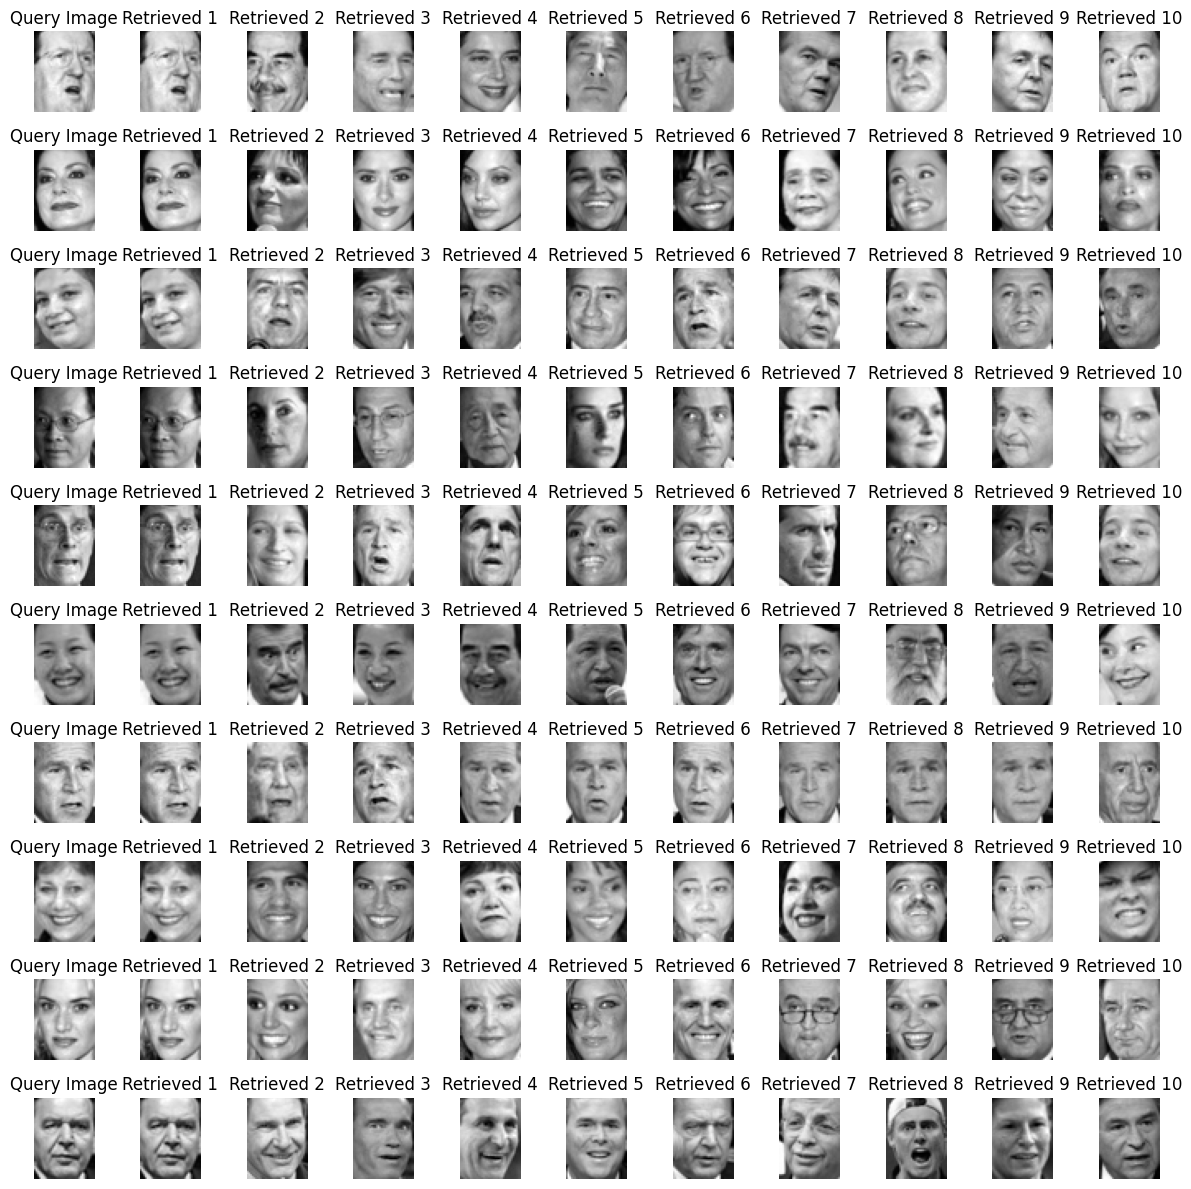

In [10]:
# Display visual search results
num_query_images = 10
num_retrieved_images = K

fig, axes = plt.subplots(num_query_images, num_retrieved_images + 1, figsize=(12, 12))

for i in range(num_query_images):
    query_index = np.random.randint(len(encoded_test))
    query_image = X_test[query_index].reshape(50, 37)
    axes[i, 0].imshow(query_image, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Query Image')

    retrieved = retrieved_indices[query_index]
    for j, index in enumerate(retrieved):
        retrieved_image = X_test[index].reshape(50, 37)
        axes[i, j + 1].imshow(retrieved_image, cmap='gray')
        axes[i, j + 1].axis('off')
        axes[i, j + 1].set_title(f'Retrieved {j+1}')

plt.tight_layout()
plt.show()

# References

* https://www.tensorflow.org/tutorials/generative/autoencoder#:~:text=An%20autoencoder%20is%20a%20special,representation%20back%20to%20an%20image.

* https://towardsdatascience.com/facial-reconstruction-using-autoencoders-ed945def10df

* https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/
